# Artist Investigations

In [3]:
artist_name = "Freddie Gibbs".lower()
artist_frame = scrobbles[scrobbles["artist"].str.lower() == artist_name] # FILTER SCROBBLES
artist_frame = artist_frame.sort_index(ascending=False) # SORT
# artist_frame = artist_frame.loc[:, descriptor_headers] # DESCRIPTORS

total_time = artist_frame["duration_ms"].sum() / (1000 * 60) # minutes
total_days = total_time / (60 * 24) # days
print(f'{artist_frame.count()[0]:,d} scrobbles')
print(f'{total_days:.0f} days spent listening since Nov. 2017')
print(f'{total_time / days_since(first_day).days:.2f} minutes/day')

artist_frame.describe()[1:]

1,706 scrobbles
4 days spent listening since Nov. 2017
4.62 minutes/day


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.218702,0.574796,202421.407595,0.678473,0.053497,5.482911,0.305708,-8.005934,0.695570,0.289666,110.452840,3.996203,0.511429
std,0.215092,0.162472,59794.180372,0.141701,0.186326,3.492010,0.180859,2.022733,0.460311,0.132537,32.528693,0.177908,0.198530
min,0.000843,0.256000,48507.000000,0.176000,0.000000,0.000000,0.052900,-16.918000,0.000000,0.029600,56.046000,3.000000,0.038300
25%,0.049700,0.451000,154573.000000,0.584000,0.000000,1.000000,0.139000,-9.134000,0.000000,0.203000,87.786000,4.000000,0.373000
50%,0.161000,0.543000,199053.000000,0.668000,0.000004,6.000000,0.303000,-8.320000,1.000000,0.299000,91.973000,4.000000,0.516000
75%,0.274000,0.657000,226520.000000,0.805000,0.000648,8.000000,0.399000,-6.442000,1.000000,0.380000,130.990000,4.000000,0.638000
max,0.946000,0.948000,513707.000000,0.946000,0.901000,11.000000,0.796000,-2.002000,1.000000,0.749000,188.050000,5.000000,0.959000


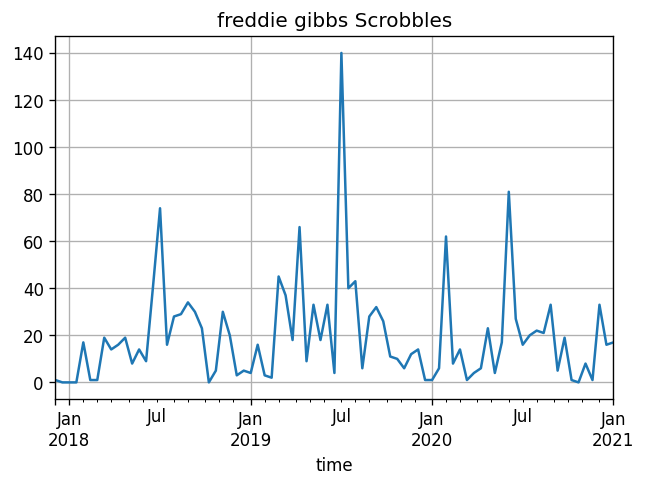

In [11]:
filtered_artist = scrobbles[scrobbles["artist"].str.lower() == artist_name]
# resample by day and mean
filtered_artist = filtered_artist.resample("2W").count()

filtered_artist["energy"].plot()

plt.title(f"{artist_name} Scrobbles")
plt.grid()
plt.show()

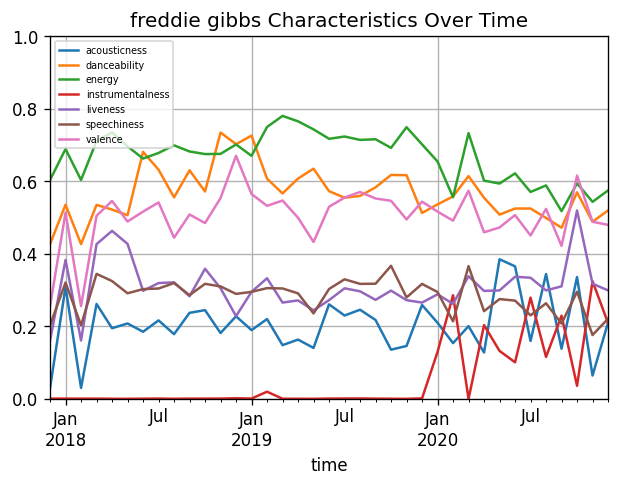

In [5]:
filtered_artist = scrobbles[scrobbles["artist"].str.lower() == artist_name]
# select only descriptor float columns
filtered_artist = filtered_artist.loc[:, float_headers]
# resample by day and mean
filtered_artist = filtered_artist.resample("1M").mean()

# filtered_playlist["energy"].plot()
filtered_artist.plot()

plt.title(f"{artist_name} Characteristics Over Time")
plt.legend(loc = "upper left", fontsize = "xx-small")
plt.ylim([0, 1])
plt.grid()
plt.show()

# Artist Listening Time

In [48]:
limit = 35
artists = fmnet.top_artists(period=fmnet.Range.OVERALL, limit=limit)

filtered_artists = [scrobbles[scrobbles["artist"] == i.name] for i in artists]

### STATS ###
# total time listening to artists 
artists_time = [i["duration_ms"].sum() for i in filtered_artists]
# total number of tracks
artists_track_count = np.array([i.drop_duplicates(["uri"]).count()[0] for i in filtered_artists])
# average length of artist's tracks (ms)
artists_average_track_length = np.array([i.drop_duplicates(["uri"])["duration_ms"].mean() for i in filtered_artists])

fig_size = (7,(5/20)*limit)

For these charts the ordering is left as retrieved from the API, i.e by most played.

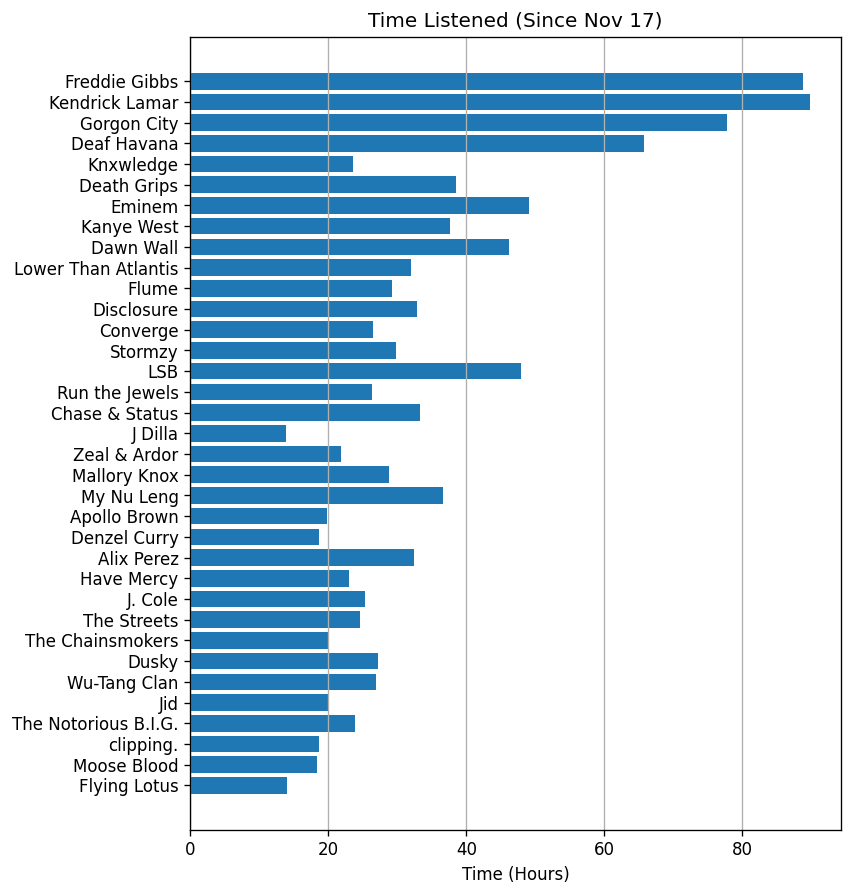

In [49]:
plt.figure(figsize=fig_size)
plt.barh(np.arange(len(artists))[::-1], np.array(artists_time) / (1000 * 60 * 60) )
plt.yticks(np.arange(len(artists))[::-1], labels=[i.name for i in artists])
plt.xlabel("Time (Hours)")
plt.grid(axis="x")
plt.title("Time Listened (Since Nov 17)")
plt.show()

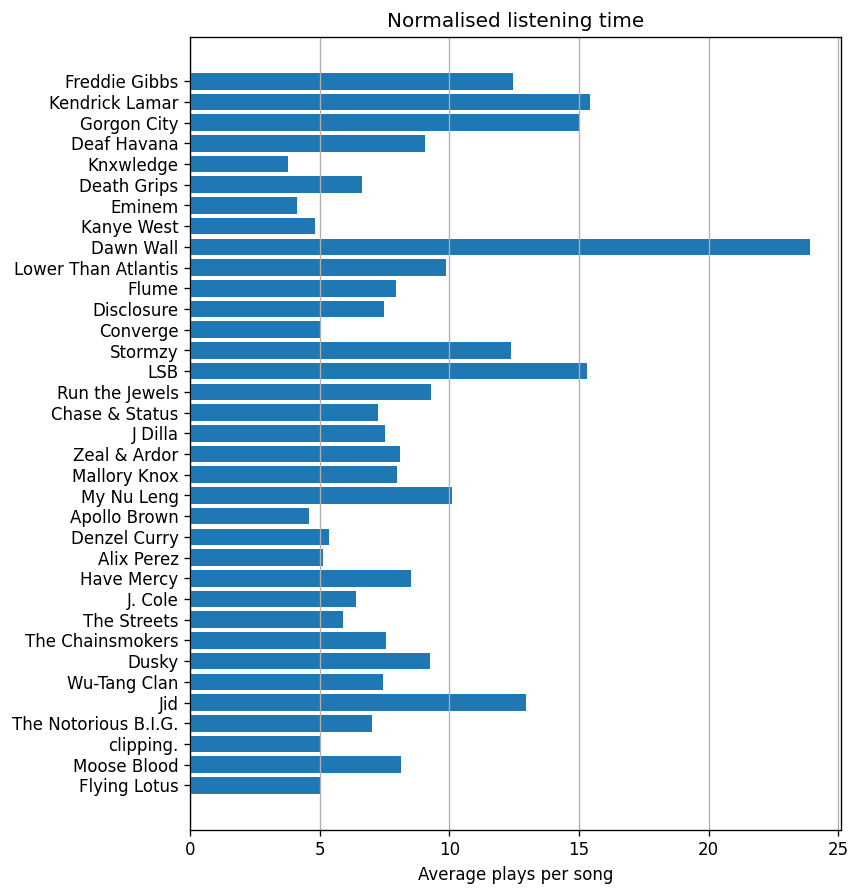

In [50]:
plt.figure(figsize=fig_size)
plt.barh(np.arange(len(artists))[::-1], np.array(artists_time) / (artists_track_count * artists_average_track_length) )
plt.yticks(np.arange(len(artists))[::-1], labels=[i.name for i in artists])
plt.xlabel("Average plays per song")
plt.grid(axis="x")
plt.title("Normalised listening time")
plt.show()

# Imports & Setup

In [1]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_fmnet, get_playlist, track_frame
from analysis.query import *
from analysis import float_headers, days_since

import pandas as pd
import numpy as np

client = bigquery.Client()
spotnet = get_spotnet()
fmnet = get_fmnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [2]:
scrobbles = get_query(cache=cache)

## Write Scrobble Frame

In [ ]:
scrobbles.reset_index().to_csv(cache, sep='\t')